# Post factorization analysis 

The purpose of this notebook is to analyse the results of the MOFA factorization of the target dataset.

Firstly differential factors are identified and then assessed with GSEA.

In [ ]:
# libraries
library(MOFA2)
library(rhdf5)
library(rjson)
library(dplyr)
library(ggplot2)
library(RColorBrewer)
library(fgsea)
library(msigdbr)

## SET SEED
Seed = 1234567
mode(Seed) = 'integer'
set.seed(Seed)

In [2]:
##
### parameters and directories
##

TopD = 5000

InDir = file.path('RawData')

## various choices for the factorization directory

FctrznDir = file.path(
  paste0('Trg_MS_PN_', TopD,"D"),
  "MOFA", "Fctrzn_6K_01TH"
  )


In [3]:
## import metadata
smpls = read.table(
  file.path(InDir,"phenodata_RNAseq.tsv"),
  header = TRUE
)
# tidy and filter sample names
smpls$Sample = sub("[.]","-",smpls$Sample)
smpls = smpls[is.element(smpls$HGCC,c("MS", "PN")),]

# add case control variable if testing cancer vs healthy
smpls$CaseControl = smpls$HGCC
smpls$CaseControl[smpls$CaseControl!='Normal']='Case'

In [4]:
# import factorization
InputModel = file.path(FctrznDir,"Model.hdf5")
Fctrzn = load_model(file = InputModel)
Zmu = Fctrzn@expectations$Z$group0


In [5]:
# filter and order samples
smpls = smpls[is.element(smpls$Sample,rownames(Zmu)),]
Zmu = Zmu[smpls$Sample,]

print(smpls)
print(Zmu)

   Sample HGCC clusterGliovis MGMTstatus CaseControl
5   U3047   PN             PN          M        Case
6   U3013   PN             PN          U        Case
7   U3117   PN             PN          M        Case
11  U3071   MS             MS          U        Case
12  U3073   MS             MS          M        Case
13  U3020   MS             MS          U        Case
         Factor1    Factor2    Factor3     Factor4     Factor5
U3047 -0.5769219  3.4671240 -0.3470322 -0.02880814 -0.90303765
U3013 -1.4991924 -1.4983603 -1.4347992 -0.20808586 -0.85846862
U3117 -1.3109933  0.7541550 -0.2986068  0.03934680  2.02254771
U3071 -1.8695885 -1.1627273  2.0648877  0.23104324 -0.55011729
U3073  2.5605430 -0.6349472  0.4774579 -0.74526719  0.24222137
U3020  2.6961530 -0.9252442 -0.4619075  0.71177115  0.04685447


In [6]:
# test for differentially active factors
# sample_group = as.factor(smpls$CaseControl)
sample_group = as.factor(smpls$HGCC)

# test if can use wilcox
minSamples = min(unlist(table(sample_group)))
# testing function
DifFactTester = function(x, minSamples) {
  if (minSamples >= 4) {
    wilcox.test(x ~ sample_group)$p.value
  } else {
    t.test(x ~ sample_group)$p.value
  }
}
Z_pv = apply(X = Zmu, MARGIN = 2, FUN = DifFactTester, minSamples = minSamples)
Z_pv = p.adjust(Z_pv, method="BH")
print(Z_pv)
Z_pv_sig = which(Z_pv < 0.05)
names(Z_pv_sig) = names(Z_pv)[Z_pv_sig]
print(Z_pv_sig)

  Factor1   Factor2   Factor3   Factor4   Factor5 
0.5551983 0.5551983 0.5551983 0.8759178 0.8759178 
named integer(0)


For all case vs normal, or subtype vs normal - factor 1 (only) is always differentially active
For subtype vs subtype - no factors are differentilly active

             mRNA     DNAme
Factor1 84.566788 87.801796
Factor2  4.970752  5.527329
Factor3  4.841804  5.445169


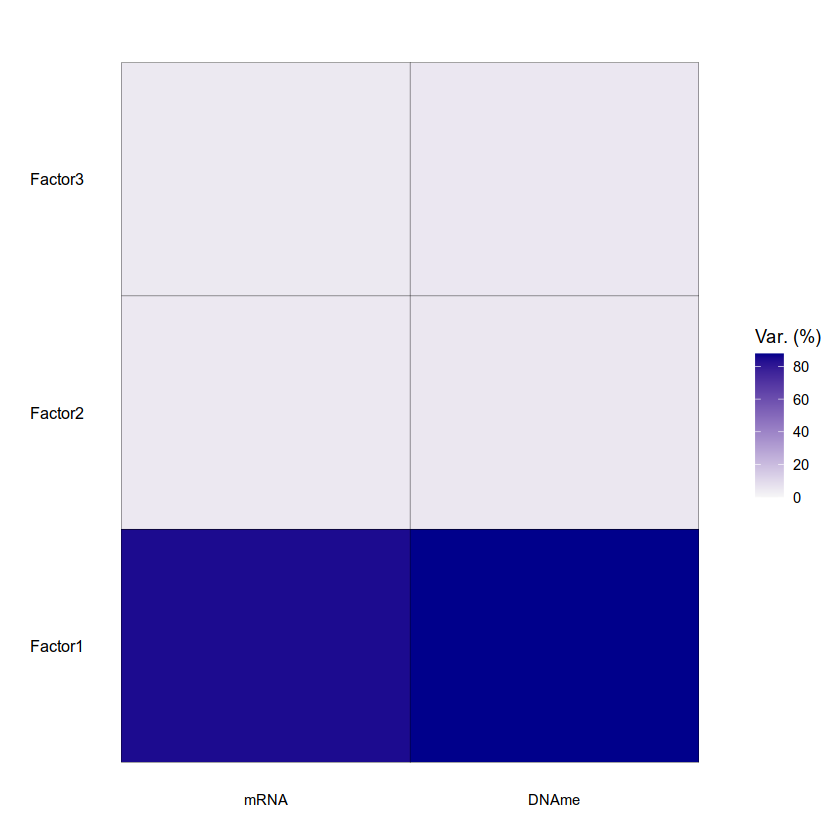

In [7]:
# Check variance explained by factor
varexp = Fctrzn@cache$variance_explained$r2_per_factor[[1]]
print(varexp)
plot_variance_explained(Fctrzn)

In [ ]:
# GSEA mRNA weights vectors of interest
GroupsTested = paste(levels(sample_group),collapse='_vs_')
W = Fctrzn@expectations$W
ScaleW = function(x) {
  x/norm(matrix(x),type="F")
}
W_mRNA = t(apply(W[['mRNA']],1, ScaleW))

kToTest = c('Factor1')
GenesetCatToTest = c("C2", "C2", "C5", "C5")
GenesetSubCatToTest = c("CP:KEGG", "CP:REACTOME", "GO:BP", "GO:CC")

ToTest = data.frame(
  k = rep(kToTest, each=length(GenesetCatToTest)),
  category = rep(GenesetCatToTest,times=length(kToTest)),
  subcategory = rep(GenesetSubCatToTest,times=length(kToTest))
)

SigGeneSets = apply(X = ToTest, MARGIN = 1, FUN = function(ToTestVec, WMat = W_mRNA, Groups = GroupsTested){

  k = as.character(ToTestVec[1])
  category = as.character(ToTestVec[2])
  subcategory = as.character(ToTestVec[3])
  rankings = WMat[,k]
  names(rankings) = rownames(WMat)

  gene_sets = msigdbr(
                species = "Homo sapiens", 
                category = category, 
                subcategory = subcategory
                )

  gene_sets = gene_sets %>% 
            dplyr::distinct(gs_name, ensembl_gene) %>% 
            as.data.frame()

  gene_sets = split(
      x = gene_sets$ensembl_gene, 
      f = gene_sets$gs_name
      )
  # set seed
  Seed = 1234567
  mode(Seed) = 'integer'
  set.seed(Seed)

  # run fgsea
  fgseaRes = fgsea(
      pathways = gene_sets,
      stats = rankings,
      minSize = 15,
      maxSize = 500
      )
  
  fgseaRes = fgseaRes %>% 
  dplyr::select(pathway, padj, ES, NES, size) %>% 
  as.data.frame()
  
  fgseaRes = fgseaRes[fgseaRes$padj<0.01 & !is.na(fgseaRes$padj),]
  fgseaRes$k = rep(k,nrow(fgseaRes))
  fgseaRes$subcategory = rep(subcategory,nrow(fgseaRes))
  fgseaRes$Groups = rep(Groups,nrow(fgseaRes))

  return(fgseaRes)

})

SigGeneSets = do.call(rbind, SigGeneSets)

## export as csv
write.table(SigGeneSets,
            file.path(FctrznDir, paste0('SigGeneSets','_',GroupsTested,'.csv')),
            quote = FALSE, sep=',', na='', row.names = FALSE, col.names = TRUE)
